In [173]:
books = pd.read_csv('./data/' + 'book_language_title&author&summary_embedding.csv')

In [179]:
books2 = pd.read_csv('./data/' + 'books_merged_2.csv')

In [182]:
tmp = books.drop(['publisher'], axis=1).merge(books2[['isbn', 'publisher', 'book_author_over10', 'category_high']], how='left', on='isbn')

In [187]:
tmp.columns[:20]

Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'img_url',
       'language', 'category', 'summary', 'img_path', 'new_language',
       'remove_country_code', '0', '1', '2', '3', '4', '5', '6', '7', '8'],
      dtype='object')

In [194]:
[tmp.drop(['book_title'], axis=1).columns.tolist().index(f) - 1 for f in ['isbn', 'new_language', 'publisher', 'book_author_over10', 'category_high']]

[-1, 7, 521, 522, 523]

In [189]:
tmp.drop(['book_title', 'book_author', 'img_url', 'language', 'category', 'summary', 'img_path', 'remove_country_code'], axis=1).columns

Index(['isbn', 'year_of_publication', 'new_language', '0', '1', '2', '3', '4',
       '5', '6',
       ...
       '505', '506', '507', '508', '509', '510', '511', 'publisher',
       'book_author_over10', 'category_high'],
      dtype='object', length=518)

In [188]:
tmp.to_csv('books_embedding_2.csv', index=False)

In [174]:
['isbn', 'book_title', 'book_author', 'year_of_publication'

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,...,502,503,504,505,506,507,508,509,510,511
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,...,0.781929,0.222393,0.487293,0.068784,0.037725,-1.268462,-0.750312,0.107709,-0.462396,0.383121
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,1940-1949,"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg,...,0.215752,0.093943,0.151725,-0.537121,-0.453638,-0.858057,-0.290574,-0.710232,-0.775910,-0.211170
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,medical,"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg,...,0.647762,0.017774,-0.340387,-0.186091,-0.065213,0.268273,-1.180975,0.385781,0.077389,0.683517
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,fiction,A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg,...,1.110681,-0.826044,-0.892639,0.164168,-0.205375,-0.245697,-0.806942,1.030093,0.396518,0.037680
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,history,"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg,...,-0.153706,0.628128,0.500611,0.919893,-1.029661,-1.536474,-1.166991,-0.001767,0.096962,0.329258


In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 0
    elif x >= 20 and x < 30:
        return 1
    elif x >= 30 and x < 40:
        return 2
    elif x >= 40 and x < 50:
        return 3
    elif x >= 50 and x < 60:
        return 4
    else:
        return 5

def process_context_data(users, books, ratings1, ratings2):
    
    # isbn 첫 네자리 활용하여 publisher 전처리
    # publisher_dict=(books['publisher'].value_counts()).to_dict()
    # publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])
    # publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

    # modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
    # for publisher in modify_list:
    #     try:
    #         number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
    #         right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
    #         books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    #     except: 
    #         pass

    ratings = pd.concat([ratings1, ratings2]).reset_index(drop=True)
    
    # 인덱싱 처리된 데이터 조인
    context_df = ratings.merge(users, on='user_id', how='left').merge(books.drop(['book_title', 'book_author', 'img_url', 'language', 'category', 'summary', 'img_path', 'remove_country_code'], axis=1), on='isbn', how='left')
    train_df = ratings1.merge(users, on='user_id', how='left').merge(books.drop(['book_title', 'book_author', 'img_url', 'language', 'category', 'summary', 'img_path', 'remove_country_code'], axis=1), on='isbn', how='left')
    test_df = ratings2.merge(users, on='user_id', how='left').merge(books.drop(['book_title', 'book_author', 'img_url', 'language', 'category', 'summary', 'img_path', 'remove_country_code'], axis=1), on='isbn', how='left')

    # user_power
    tmp = train_df.groupby('user_id')['isbn'].count().reset_index()
    tmp.columns = list(tmp.columns)[:-1] + ['user_power']
    context_df = context_df.merge(tmp, how='left', on='user_id')
    context_df['user_power'] = context_df['user_power'].fillna(0)
    train_df = train_df.merge(tmp, how='left', on='user_id')
    test_df = test_df.merge(tmp, how='left', on='user_id')
    test_df['user_power'] = test_df['user_power'].fillna(0)

    # book_popularity
    tmp = train_df.groupby('isbn')['user_id'].count().reset_index()
    tmp.columns = list(tmp.columns)[:-1] + ['book_popularity']
    context_df = context_df.merge(tmp, how='left', on='isbn')
    context_df['book_popularity'] = context_df['book_popularity'].fillna(0)
    train_df = train_df.merge(tmp, how='left', on='isbn')
    test_df = test_df.merge(tmp, how='left', on='isbn')
    test_df['book_popularity'] = test_df['book_popularity'].fillna(0)
    
    # 인덱싱 처리
    loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
    loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
    loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

    train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
    train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
    train_df['location_country'] = train_df['location_country'].map(loc_country2idx)
    test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
    test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
    test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

    train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
    # train_df['age'] = train_df['age'].apply(age_map)
    test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
    # test_df['age'] = test_df['age'].apply(age_map)

    # book 파트 인덱싱
    category2idx = {v:k for k,v in enumerate(context_df['category_high'].unique())}
    publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
    language2idx = {v:k for k,v in enumerate(context_df['new_language'].unique())}
    author2idx = {v:k for k,v in enumerate(context_df['book_author_over10'].unique())}
    # yearofpublication2idx = {v:k for k,v in enumerate(context_df['year_of_publication'].unique())}
    # user_power2idx = {v:k for k,v in enumerate(context_df['user_power'].unique())}
    # book_popularity2idx = {v:k for k,v in enumerate(context_df['book_popularity'].unique())}

    train_df['category_high'] = train_df['category_high'].map(category2idx)
    train_df['publisher'] = train_df['publisher'].map(publisher2idx)
    train_df['new_language'] = train_df['new_language'].map(language2idx)
    train_df['book_author_over10'] = train_df['book_author_over10'].map(author2idx)
    # train_df['year_of_publication'] = train_df['year_of_publication'].map(yearofpublication2idx)
    # train_df['user_power'] = train_df['user_power'].map(user_power2idx)
    # train_df['book_popularity'] = train_df['book_popularity'].map(book_popularity2idx)

    test_df['category_high'] = test_df['category_high'].map(category2idx)
    test_df['publisher'] = test_df['publisher'].map(publisher2idx)
    test_df['new_language'] = test_df['new_language'].map(language2idx)
    test_df['book_author_over10'] = test_df['book_author_over10'].map(author2idx)
    # test_df['year_of_publication'] = test_df['year_of_publication'].map(yearofpublication2idx)
    # test_df['user_power'] = test_df['user_power'].map(user_power2idx)
    # test_df['book_popularity'] = test_df['book_popularity'].map(book_popularity2idx)

    idx = {
        "loc_city2idx":loc_city2idx,
        "loc_state2idx":loc_state2idx,
        "loc_country2idx":loc_country2idx,
        "category2idx":category2idx,
        "publisher2idx":publisher2idx,
        "language2idx":language2idx,
        "author2idx":author2idx,
        # "yearofpublication2idx":yearofpublication2idx,
        # "user_power2idx":user_power2idx,
        # "book_popularity2idx":book_popularity2idx,
    }
    return idx, train_df, test_df


def context_data_load(data_path):

    ######################## DATA LOAD
    # users = pd.read_csv(args.DATA_PATH + 'users.csv')
    users = pd.read_csv(data_path + 'users_preprocessed.csv')
    books = pd.read_csv(data_path + 'books_embedding_2.csv')
    train = pd.read_csv(data_path + 'train_ratings.csv')
    test = pd.read_csv(data_path + 'test_ratings.csv')
    sub = pd.read_csv(data_path + 'sample_submission.csv')

    ids = pd.concat([train['user_id'], sub['user_id']]).unique()
    isbns = pd.concat([train['isbn'], sub['isbn']]).unique()

    idx2user = {idx:id for idx, id in enumerate(ids)}
    idx2isbn = {idx:isbn for idx, isbn in enumerate(isbns)}

    user2idx = {id:idx for idx, id in idx2user.items()}
    isbn2idx = {isbn:idx for idx, isbn in idx2isbn.items()}

    train['user_id'] = train['user_id'].map(user2idx)
    sub['user_id'] = sub['user_id'].map(user2idx)
    test['user_id'] = test['user_id'].map(user2idx)
    users['user_id'] = users['user_id'].map(user2idx)

    train['isbn'] = train['isbn'].map(isbn2idx)
    sub['isbn'] = sub['isbn'].map(isbn2idx)
    test['isbn'] = test['isbn'].map(isbn2idx)
    books['isbn'] = books['isbn'].map(isbn2idx)

    idx, context_train, context_test = process_context_data(users, books, train, test)

    # context_train = context_train.drop(['publisher', 'book_author_over10', 'category_high'], axis=1)
    # context_test = context_test.drop(['publisher', 'book_author_over10', 'category_high'], axis=1)

    field_dims = np.array([len(user2idx), len(isbn2idx),
                            len(idx['loc_city2idx']), 
                            len(idx['loc_state2idx']), len(idx['loc_country2idx']),
                            len(idx['language2idx']), 
                            len(idx['publisher2idx']),
                            len(idx['author2idx']),
                            len(idx['category2idx']), 
                            # len(idx['yearofpublication2idx']),
                            ], dtype=np.uint32)
    cat_idxs = [context_train.drop(['rating'], axis=1).columns.tolist().index(f) for f in ['user_id', 'isbn', 'location_city', 'location_state', 'location_country', 'new_language', 'publisher', 'book_author_over10', 'category_high']]

    data = {
            'train':context_train,
            'test':context_test.drop(['rating'], axis=1),
            'field_dims':field_dims,
            'cat_idxs':cat_idxs,
            'users':users,
            'books':books,
            'sub':sub,
            'idx2user':idx2user,
            'idx2isbn':idx2isbn,
            'user2idx':user2idx,
            'isbn2idx':isbn2idx,
            "loc_city2idx":idx['loc_city2idx'],
            "loc_state2idx":idx['loc_state2idx'],
            "loc_country2idx":idx['loc_country2idx'],
            "category2idx":idx['category2idx'],
            "publisher2idx":idx['publisher2idx'],
            "language2idx":idx['language2idx'],
            "author2idx":idx['author2idx'],
            # "yearofpublication2idx":idx['yearofpublication2idx']
            }


    return data


def context_data_split(test_size, seed, data):
    X_train, X_valid, y_train, y_valid = train_test_split(
                                                        data['train'].drop(['rating'], axis=1),
                                                        data['train']['rating'],
                                                        test_size=test_size,
                                                        random_state=seed,
                                                        shuffle=True
                                                        )
    data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid
    return data

def context_data_loader(batch_size, data_shuffle, data):
    train_dataset = TensorDataset(torch.LongTensor(data['X_train'].values), torch.LongTensor(data['y_train'].values))
    valid_dataset = TensorDataset(torch.LongTensor(data['X_valid'].values), torch.LongTensor(data['y_valid'].values))
    test_dataset = TensorDataset(torch.LongTensor(data['test'].values))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=data_shuffle)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=data_shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    data['train_dataloader'], data['valid_dataloader'], data['test_dataloader'] = train_dataloader, valid_dataloader, test_dataloader

    return data


In [2]:
import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from src.models._models import _FactorizationMachineModel, _FieldAwareFactorizationMachineModel
from src.models._models import rmse, RMSELoss


class FactorizationMachineModel:

    def __init__(self, fm_embed_dim, epochs, lr, weight_decay, device, data):
        super().__init__()

        self.criterion = RMSELoss()

        self.train_dataloader = data['train_dataloader']
        self.valid_dataloader = data['valid_dataloader']
        self.field_dims = data['field_dims']

        self.embed_dim = fm_embed_dim
        self.epochs = epochs
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.log_interval = 100

        self.device = device

        self.model = _FactorizationMachineModel(self.field_dims, self.embed_dim).to(self.device)
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, amsgrad=True, weight_decay=self.weight_decay)


    def train(self):
      # model: type, optimizer: torch.optim, train_dataloader: DataLoader, criterion: torch.nn, device: str, log_interval: int=100
        train_result = pd.DataFrame(np.zeros((self.epochs, 2)))
        train_result.columns = ['train_rmse', 'valid_rmse']
        
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            
            tk0 = tqdm.tqdm(self.train_dataloader, smoothing=0, mininterval=1.0)
            for i, (fields, target) in enumerate(tk0):
                self.model.zero_grad()
                fields, target = fields.to(self.device), target.to(self.device)

                y = self.model(fields)
                loss = self.criterion(y, target.float())

                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                if (i + 1) % self.log_interval == 0:
                    tk0.set_postfix(loss=total_loss / self.log_interval)
                    total_loss = 0

            # train_rmse
            self.model.eval()
            targets, predicts = list(), list()
            with torch.no_grad():
                for fields, target in tqdm.tqdm(self.train_dataloader, smoothing=0, mininterval=1.0):
                    fields, target = fields.to(self.device), target.to(self.device)
                    y = self.model(fields)
                    targets.extend(target.tolist())
                    predicts.extend(y.tolist())
            rmse_score_train = rmse(targets, predicts)

            rmse_score = self.predict_train()
            print('epoch:', epoch, 'train: rmse:', rmse_score_train, 'validation: rmse:', rmse_score)
            train_result['train_rmse'][epoch] = rmse_score_train
            train_result['valid_rmse'][epoch] = rmse_score
        return train_result


    def predict_train(self):
        self.model.eval()
        targets, predicts = list(), list()
        with torch.no_grad():
            for fields, target in tqdm.tqdm(self.valid_dataloader, smoothing=0, mininterval=1.0):
                fields, target = fields.to(self.device), target.to(self.device)
                y = self.model(fields)
                targets.extend(target.tolist())
                predicts.extend(y.tolist())
        return rmse(targets, predicts)


    def predict(self, dataloader):
        self.model.eval()
        predicts = list()
        with torch.no_grad():
            for fields in tqdm.tqdm(dataloader, smoothing=0, mininterval=1.0):
                fields = fields[0].to(self.device)
                y = self.model(fields)
                predicts.extend(y.tolist())
        return predicts

In [3]:
data_path = './data/'
test_size = 0.2
seed = 42
batch_size = 1024
data_shuffle = False
fm_embed_dim = 4
epochs = 10
lr = 1e-3
weight_decay = 1e-6
device = 'cuda'

In [4]:
from src import seed_everything
seed_everything(seed)

In [5]:
data = context_data_load(data_path)
data = context_data_split(test_size, seed, data)
data = context_data_loader(batch_size, data_shuffle, data)


In [6]:
data['cat_idxs']

[0, 1, 3, 4, 5, 7, 520, 521, 522]

In [7]:
data['field_dims'].tolist()

[68069, 149570, 1561, 400, 200, 41, 1523, 2105, 413]

In [17]:
data['X_train'].filter(regex=r'(^\d+$)|(isbn)|(user_id)')

,user_id,isbn,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
121312,22946,15310,0.367151,-0.251446,-0.145368,-0.375025,0.298992,-0.050751,0.080030,-0.443323,...,-0.530806,0.359316,-0.507129,0.201233,-0.010361,-0.248660,-0.094754,-0.195462,-0.404890,0.230677
265089,44452,91405,-0.138239,-0.067160,-0.098521,0.035951,-0.203669,0.416204,-0.065353,0.068401,...,-0.038368,-0.120319,-0.181464,-0.002622,0.149799,0.028527,-0.148239,-0.049282,-0.000555,-0.084439
60236,15913,4800,0.475476,0.213558,-0.135985,0.666690,0.634971,0.019742,0.223108,-0.073898,...,0.908713,0.351339,0.180549,0.391470,0.397474,0.493451,-2.218506,-0.093176,-0.809460,-2.091022
111218,1339,13043,0.748002,1.259077,-1.053750,-0.596817,-1.035608,0.680889,-0.442341,0.214319,...,0.365840,-0.109428,1.806208,1.038296,1.179758,0.409602,-1.094259,1.144197,-0.152073,0.542168
306001,15663,128985,-0.218161,-0.204154,0.072122,-0.026755,0.001594,-0.100305,-0.315409,-0.264142,...,0.264723,-0.102539,0.022473,0.124385,-0.148589,-0.047239,-0.598339,0.292300,-0.359550,0.035670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,2752,14936,-0.735884,-0.794855,-0.369810,0.123175,0.344034,-0.207459,-0.176074,-0.132493,...,0.833478,0.613187,-0.118592,-0.214197,0.216830,-0.705241,-0.714494,-0.770277,-0.997114,-0.465768
259178,8108,86566,-0.191200,0.047577,0.311900,0.108265,0.176241,-0.338239,0.312732,0.051957,...,-0.120315,0.396035,0.253371,-0.038501,0.163983,-0.011705,0.026754,0.101587,0.263321,-0.286075
131932,10534,18168,0.360146,0.160524,-0.134133,-0.277489,0.309494,-0.079453,-0.294350,-0.130181,...,0.129309,-0.111319,0.135668,0.003881,0.096658,-0.315464,-0.054673,-0.018506,-0.429400,0.218917
146867,40246,22419,1.035096,-0.328428,-0.384678,0.131616,-0.264417,0.150670,0.099595,-0.225185,...,0.683837,0.319497,0.792773,-0.150459,-0.360926,-0.487812,0.330318,0.177539,-0.132376,0.473766


In [20]:
from pytorch_tabnet.tab_model import TabNetRegressor

# reg = TabNetRegressor()
reg = TabNetRegressor(cat_idxs=data['cat_idxs'], 
                      cat_dims=data['field_dims'].tolist(),
                      cat_emb_dim=1,
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params=dict(lr=1e-2),
                    #   scheduler_params={"step_size":50,
                    #                     "gamma":0.9},
                    #   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      mask_type='sparsemax')

max_epochs = 150

reg.fit(
    X_train=data['X_train'].values, y_train=data['y_train'].values.reshape(-1,1),
    eval_set=[(data['X_train'].values, data['y_train'].values.reshape(-1,1)), (data['X_valid'].values, data['y_valid'].values.reshape(-1,1))],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.42723 | train_rmse: 2.48947 | valid_rmse: 2.49347 |  0:00:35s
epoch 1  | loss: 5.94555 | train_rmse: 2.43111 | valid_rmse: 2.42951 |  0:01:11s
epoch 2  | loss: 5.88485 | train_rmse: 2.41764 | valid_rmse: 2.41765 |  0:01:47s
epoch 3  | loss: 5.83522 | train_rmse: 2.41213 | valid_rmse: 2.41186 |  0:02:23s
epoch 4  | loss: 5.82638 | train_rmse: 2.40764 | valid_rmse: 2.40774 |  0:02:58s
epoch 5  | loss: 5.81129 | train_rmse: 2.40551 | valid_rmse: 2.40566 |  0:03:35s
epoch 6  | loss: 5.81177 | train_rmse: 2.40622 | valid_rmse: 2.40589 |  0:04:12s
epoch 7  | loss: 5.80831 | train_rmse: 2.41083 | valid_rmse: 2.41161 |  0:04:47s


KeyboardInterrupt: 

In [159]:
predicts = list()
for fields in tqdm.tqdm(data['test_dataloader'], smoothing=0, mininterval=1.0):
    fields = fields[0].to(device)
    y = reg.predict(fields)
    predicts.extend(y.tolist())

100%|██████████| 75/75 [00:02<00:00, 37.33it/s]


In [160]:
predicts

[[7.144058704376221],
 [7.17066764831543],
 [7.344682216644287],
 [7.459592819213867],
 [7.153656482696533],
 [7.033341884613037],
 [7.035043716430664],
 [7.0414204597473145],
 [7.1966023445129395],
 [7.1897172927856445],
 [7.00791597366333],
 [6.998721599578857],
 [7.185723304748535],
 [7.052914142608643],
 [7.062711238861084],
 [7.117008209228516],
 [6.429738998413086],
 [6.9941487312316895],
 [7.255444049835205],
 [7.154365539550781],
 [7.280552387237549],
 [7.191208362579346],
 [7.178856372833252],
 [6.943192481994629],
 [6.904626369476318],
 [7.047489643096924],
 [7.3799943923950195],
 [7.171308994293213],
 [7.272741794586182],
 [7.099232196807861],
 [7.222009658813477],
 [7.081374168395996],
 [7.278255939483643],
 [7.130725860595703],
 [6.934416770935059],
 [7.4639892578125],
 [7.071094989776611],
 [7.223353862762451],
 [6.961994171142578],
 [6.988147258758545],
 [6.983443260192871],
 [6.874877452850342],
 [5.75441837310791],
 [7.0563554763793945],
 [7.142385482788086],
 [7.30478

In [ ]:
model = FactorizationMachineModel(fm_embed_dim, epochs, lr, weight_decay, device, data)



In [7]:
train_result = model.train()

  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 0 train: rmse: 2.8989648071169296 validation: rmse: 2.949526435000278


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 1 train: rmse: 2.416116866932848 validation: rmse: 2.5377172211927017


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 2 train: rmse: 2.2215143441466245 validation: rmse: 2.4138887835958007


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 3 train: rmse: 2.0841657154563467 validation: rmse: 2.3461940414802247


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 4 train: rmse: 1.9745164241284334 validation: rmse: 2.3046313941938177


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 5 train: rmse: 1.8826895826255219 validation: rmse: 2.278793528965923


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 6 train: rmse: 1.803930054351694 validation: rmse: 2.2634218053312103


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 7 train: rmse: 1.7354935440168051 validation: rmse: 2.2552915360138415


  0%|          | 0/240 [00:00<?, ?it/s]

epoch: 8 train: rmse: 1.6755959129399307 validation: rmse: 2.2523281657417527


100%|██████████| 60/60 [00:00<00:00, 100.59it/s]

epoch: 9 train: rmse: 1.6229548248741614 validation: rmse: 2.2530417968246153


In [8]:
model.model.eval()
targets, predicts = list(), list()
with torch.no_grad():
    for fields, target in tqdm.tqdm(data['valid_dataloader'], smoothing=0, mininterval=1.0):
        fields, target = fields.to(device), target.to(device)
        y = model.model(fields)
        targets.extend(target.tolist())
        predicts.extend(y.tolist())

100%|██████████| 60/60 [00:00<00:00, 101.59it/s]


In [9]:
tmp = pd.DataFrame(data={'real_y':targets, 'pred_y':predicts})

In [10]:
pred_data = pd.concat([data2['X_valid'].reset_index(drop=True), tmp], axis=1)

In [11]:
data1.keys()

dict_keys(['train', 'test', 'field_dims', 'users', 'books', 'sub', 'idx2user', 'idx2isbn', 'user2idx', 'isbn2idx', 'loc_city2idx', 'loc_state2idx', 'loc_country2idx', 'category2idx', 'publisher2idx', 'language2idx', 'X_train', 'X_valid', 'y_train', 'y_valid', 'train_dataloader', 'valid_dataloader', 'test_dataloader'])

In [12]:
pred_data[abs(pred_data['real_y']-pred_data['pred_y']) > 2]

,user_id,isbn,age,location_city,location_state,location_country,category_high,new_language,publisher,real_y,pred_y
1,10191,13639,0,873,46,1,5,0,66,6,8.674779
6,38624,19178,1,532,61,0,5,0,13,9,6.063154
9,1044,73591,2,122,57,12,3,0,2099,6,8.333439
12,13,248,2,12,8,2,5,0,34,10,7.082018
13,48701,50990,1,649,172,45,5,3,4313,8,5.770385
...,...,...,...,...,...,...,...,...,...,...,...
61345,15043,1649,2,178,77,18,5,0,445,5,10.465378
61348,4603,61642,1,670,158,1,65,0,935,9,6.091013
61352,3627,192,2,601,12,1,5,0,63,9,6.256308
61355,6299,290,3,717,79,1,3,0,48,2,7.053584


In [31]:
idx2loc_city = {v:k for k,v in data1['loc_city2idx'].items()}
idx2loc_state = {v:k for k,v in data1['loc_state2idx'].items()}
idx2loc_country = {v:k for k,v in data1['loc_country2idx'].items()}
idx2category = {v:k for k,v in data1['category2idx'].items()}
idx2publisher = {v:k for k,v in data1['publisher2idx'].items()}
idx2language = {v:k for k,v in data1['language2idx'].items()}

pred_data['user_id'] = pred_data['user_id'].map(data1['idx2user'])
pred_data['isbn'] = pred_data['isbn'].map(data1['idx2isbn'])
pred_data['location_city'] = pred_data['location_city'].map(idx2loc_city)
pred_data['location_state'] = pred_data['location_state'].map(idx2loc_state)
pred_data['location_country'] = pred_data['location_country'].map(idx2loc_country)
pred_data['category_high'] = pred_data['category_high'].map(idx2category)
pred_data['new_language'] = pred_data['new_language'].map(idx2language)
pred_data['publisher'] = pred_data['publisher'].map(idx2publisher)

In [36]:
pred_data['goodbad'] = [1 if i <= 2 else 0 for i in abs(pred_data['real_y']-pred_data['pred_y'])]


In [39]:
pred_data.head()

,user_id,isbn,age,location_city,location_state,location_country,category_high,new_language,publisher,real_y,pred_y,goodbad
0,13149,0375702709,1,columbus,ohio,usa,african american men,en,Vintage Books USA,7,6.674837,1
1,84164,0451143752,0,annapolis,maryland,usa,NaN,en,Signet Book,6,8.674779,0
2,250405,0679439528,4,columbus,ohio,usa,NaN,en,Random House Trade,8,8.737456,1
3,174216,0440210410,2,ohio_others,ohio,usa,NaN,en,Dell Publishing Company,7,6.090610,1
4,106225,014029628X,2,chicago,illinois,usa,NaN,en,Penguin Books,9,7.542088,1


In [166]:
pred_data['pred_y'].tolist()

[6.6748366355896,
 8.674778938293457,
 8.737456321716309,
 6.090610027313232,
 7.542088031768799,
 6.977538108825684,
 6.0631537437438965,
 6.809539794921875,
 7.039185047149658,
 8.333438873291016,
 6.503687381744385,
 7.144404888153076,
 7.08201789855957,
 5.770385265350342,
 7.559856414794922,
 4.168341159820557,
 7.711973667144775,
 4.390458583831787,
 8.499451637268066,
 6.790954113006592,
 7.15049934387207,
 7.984469413757324,
 8.203104019165039,
 4.694960594177246,
 7.272351264953613,
 8.057760238647461,
 6.868237018585205,
 5.023997783660889,
 8.214590072631836,
 7.804859161376953,
 7.372303009033203,
 6.337523460388184,
 7.189598560333252,
 3.8554959297180176,
 9.687459945678711,
 7.3739190101623535,
 6.65347146987915,
 5.0805182456970215,
 7.320374011993408,
 6.843140125274658,
 7.603314399719238,
 6.78285026550293,
 7.898646831512451,
 5.055046081542969,
 5.226717948913574,
 7.496225833892822,
 6.418729305267334,
 5.7193779945373535,
 7.673104763031006,
 4.915871620178223,
 

In [163]:
def print_full(x):
    pd.set_option('display.max_rows', 500)
    print(x)
    pd.reset_option('display.max_rows')

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='index', ylabel='ratio'>

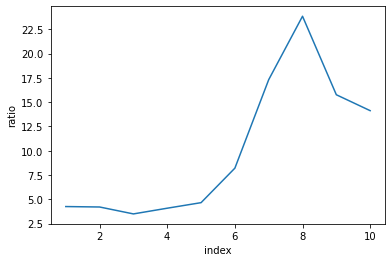

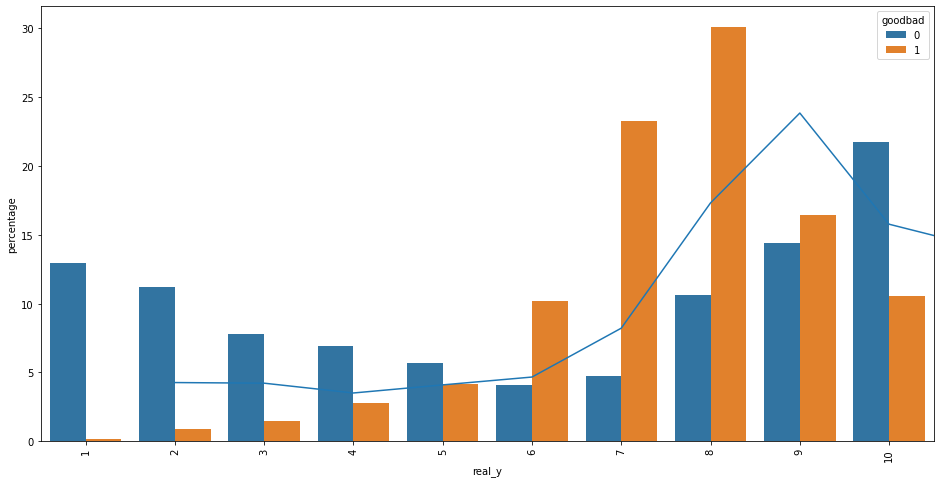

In [118]:
tmp = pred_data.groupby('goodbad')['real_y'].value_counts(normalize=True).mul(100).rename('percentage').sort_index().reset_index()
tmp2 = pred_data['real_y'].value_counts(normalize=True).mul(100).rename('ratio').sort_index().reset_index()
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
sns.lineplot(x='index', y='ratio', data=tmp2, ax=ax)
sns.barplot(x='real_y', y='percentage', data=tmp, hue='goodbad', ax=ax)
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

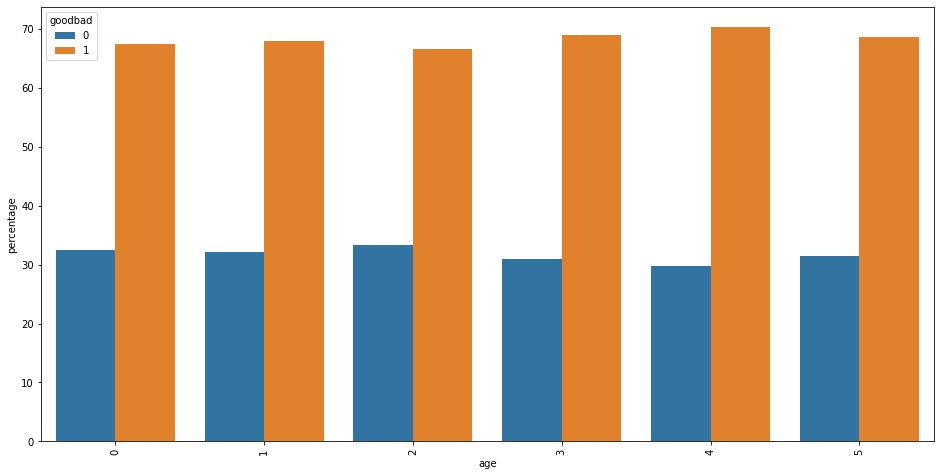

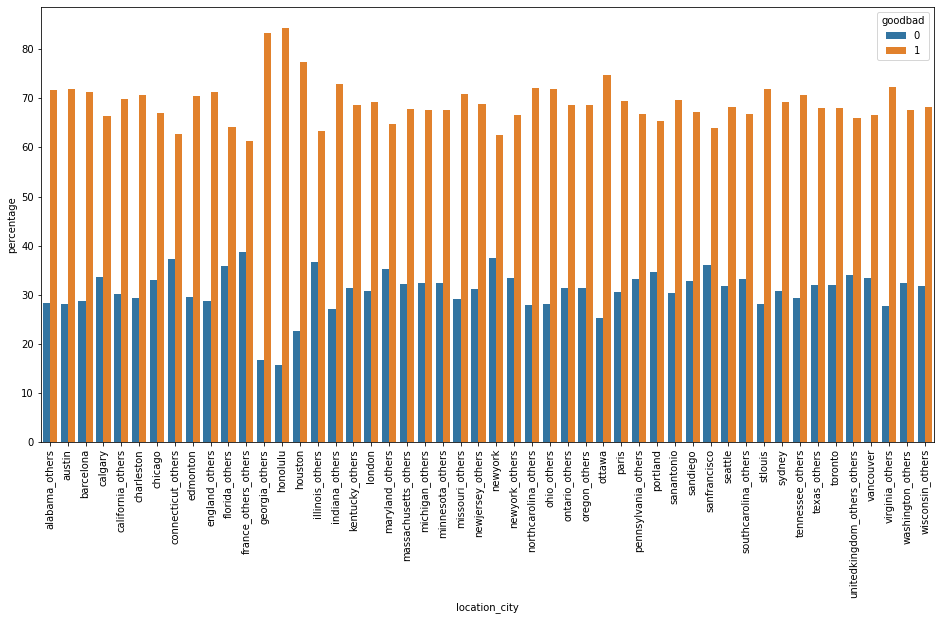

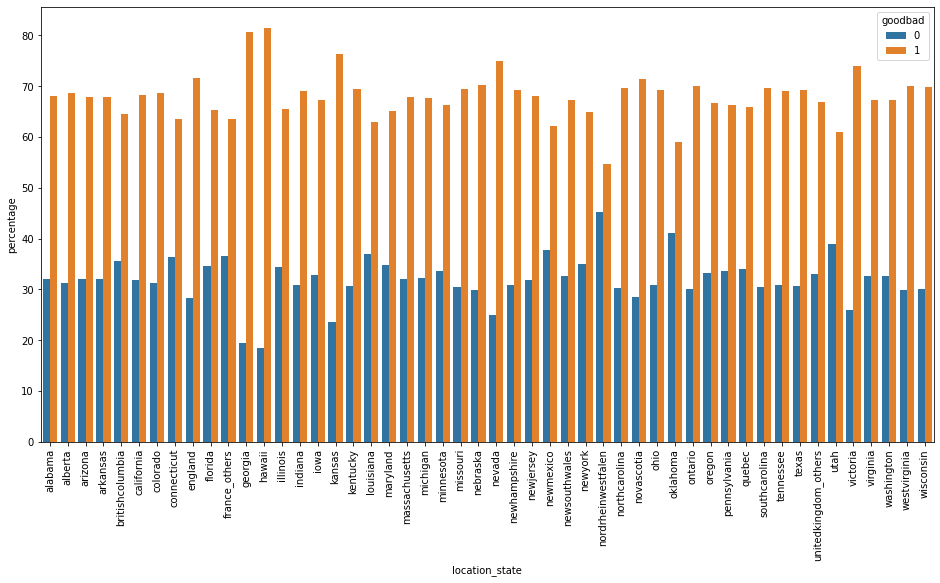

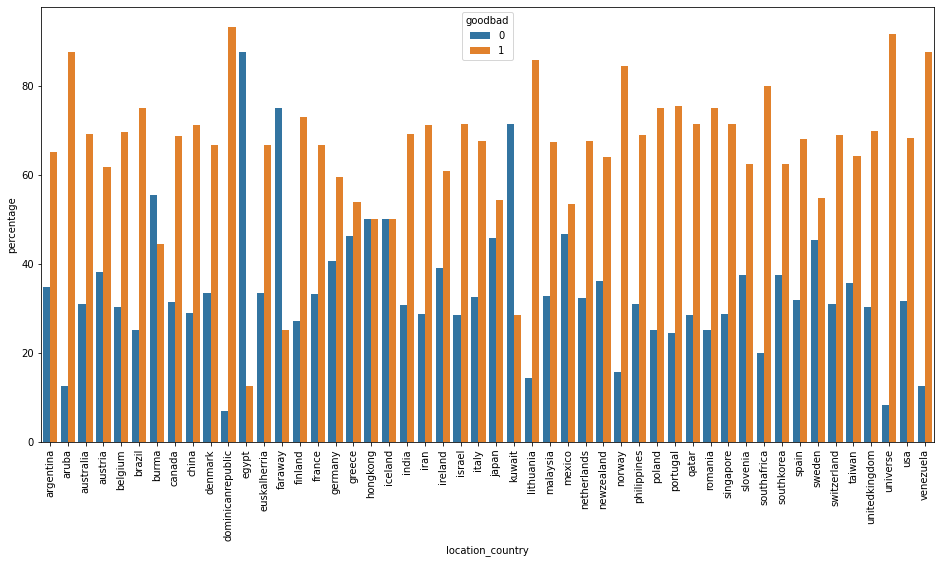

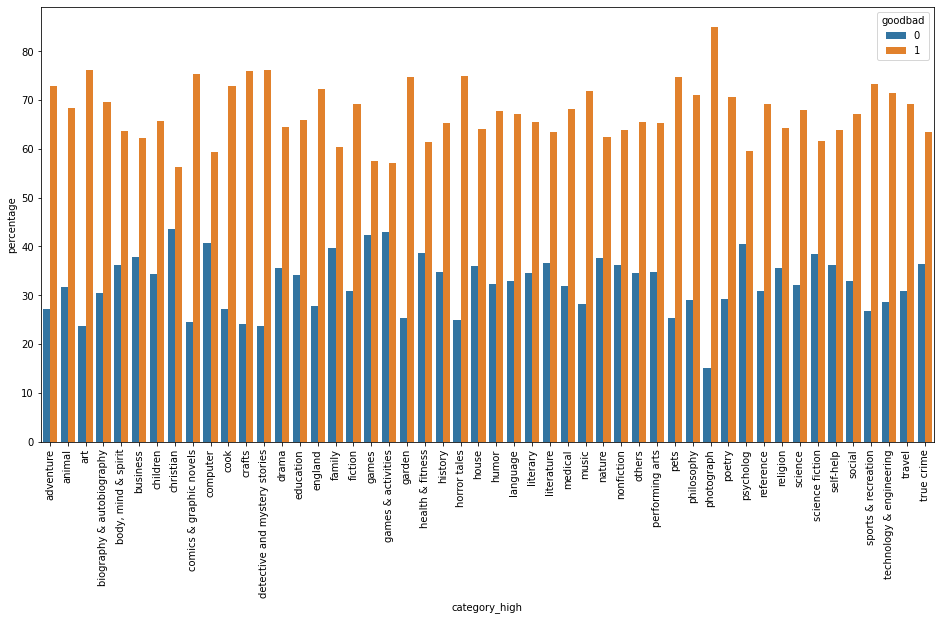

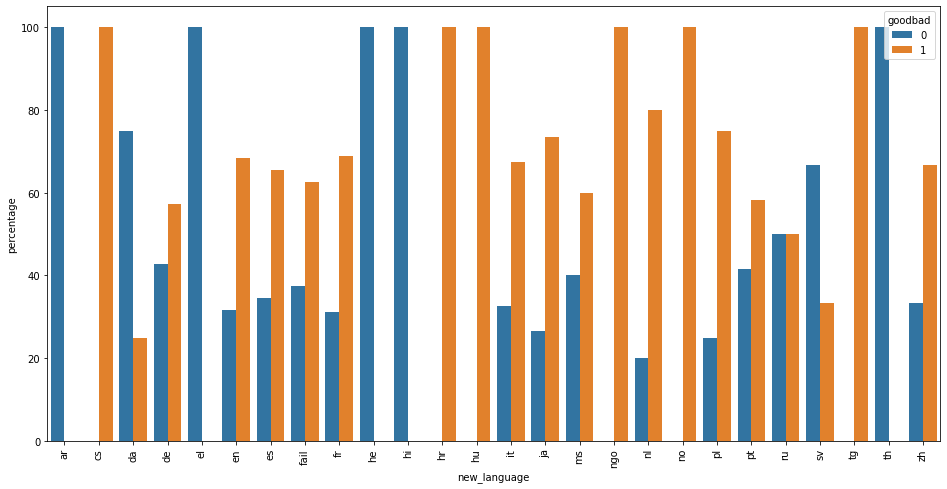

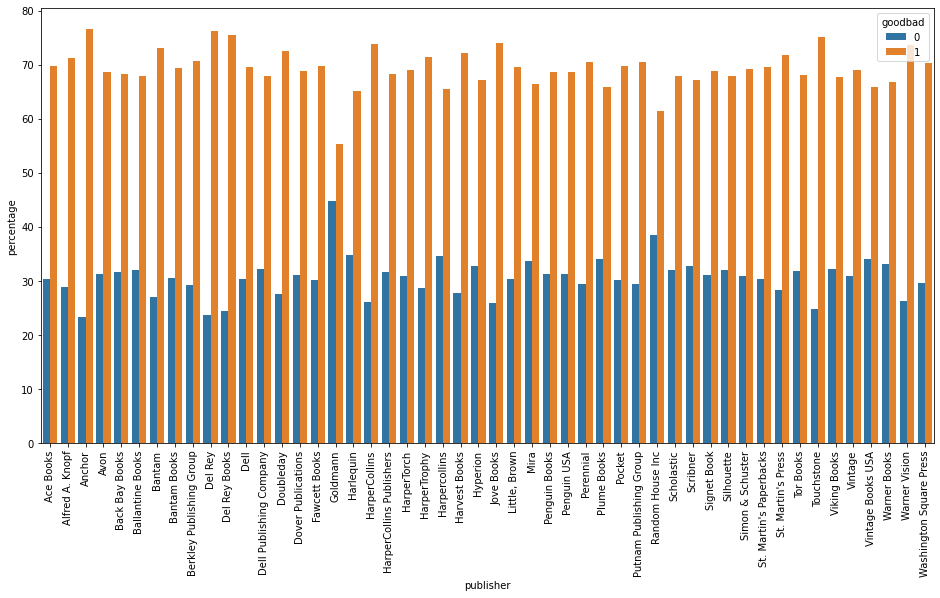

In [85]:
# print_full(pred_data.groupby('goodbad')['location_country'].value_counts())
for feature in ['age', 'location_city', 'location_state', 'location_country', 'category_high', 'new_language', 'publisher']:
    tmp2 = pred_data.groupby(feature)['goodbad'].count().sort_values(ascending=False)
    tmp = pred_data.groupby(feature)['goodbad'].value_counts(normalize=True).mul(100).rename('percentage').reset_index().sort_values(feature)
    plt.figure(figsize=(16,8))
    p = sns.barplot(x=feature, y='percentage', data=tmp[tmp[feature].isin(tmp2[:50].index)], hue='goodbad')
    _ = plt.setp(p.get_xticklabels(), rotation=90)
    plt.show()


In [130]:
tmp = pd.read_csv('./data/books_merged.csv')
tmp['new_language'].value_counts()

en      133341
de        6701
es        3772
fr        3408
it         482
nl         176
pt         161
ja          79
zh          62
fail        47
ms          42
ru          28
pl          24
sv          24
hi          19
fi          13
da          10
el           9
th           8
tg           7
no           7
cs           6
tr           4
ar           4
he           4
hu           4
ko           4
hr           4
ngo          3
bg           3
fa           2
ro           2
id           2
ca           1
is           1
lt           1
ka           1
sq           1
dz           1
uk           1
cp           1
Name: new_language, dtype: int64

In [131]:
# isbn 첫 네자리 활용하여 publisher 전처리
publisher_dict=(tmp['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
for publisher in modify_list:
    try:
        number = tmp[tmp['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = tmp[tmp['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        tmp.loc[tmp[tmp['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass
tmp['publisher'].nunique()

1523

In [133]:
tmp.to_csv('./data/books_merged_2.csv',index=False)

In [125]:
tmp.nunique()

isbn                   149570
book_title             135436
year_of_publication        95
publisher                1523
img_url                149570
language                   26
summary                 79872
img_path               149570
category_high             412
book_author             61828
book_author_over10       2105
category                 4263
new_language               41
remove_country_code    148470
dtype: int64

In [126]:
tmp.isna().sum()

isbn                       0
book_title                 0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
summary                67227
img_path                   0
category_high          68851
book_author                0
book_author_over10         0
category               69461
new_language            1100
remove_country_code     1100
dtype: int64

In [127]:
train_df = pd.read_csv('./data/train_ratings.csv')
# book_popularity
tmp = train_df.groupby('isbn')['user_id'].count().reset_index()
tmp.columns = list(tmp.columns)[:-1] + ['book_popularity']

In [129]:
tmp.nunique()

isbn               129777
book_popularity       159
dtype: int64